# Introduction

This notebook is a part of my IBM Machine Learning Professional Certificate. 

In this notebook I will perform Time Series Analysis to show how to review the data, how to preview it and how to engineering as part of my IBM Machine Learning Professional Certificate: **Specialized Models Time Series and Survival Analysis.**

# About Dataset

The dataset I want to analyze comes from [Kaggle](https://www.kaggle.com/c/acea-water-prediction)

The Acea Group is one of the leading Italian multiutility operators. Listed on the Italian Stock Exchange since 1999, the company manages and develops water and electricity networks and environmental services. Acea is the foremost Italian operator in the water services sector supplying 9 million inhabitants in Lazio, Tuscany, Umbria, Molise, Campania.

**Data:**

The reality is that each waterbody has such unique characteristics that their attributes are not linked to each other. This analytics competition uses datasets that are completely independent from each other. However, it is critical to understand total availability in order to preserve water across the country.

Each dataset represents a different kind of waterbody. As each waterbody is different from the other, the related features are also different. So, if for instance we consider a water spring we notice that its features are different from those of a lake. These variances are expected based upon the unique behavior and characteristics of each waterbody. The Acea Group deals with four different type of waterbodies: water springs, lakes, rivers and aquifers.

**Problem statement:**

The goal for this analysis will be perform EDA, together with features engineering and also perform time series forecasting.

# Import needed packages

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# seaborn setup
sns.set_style('whitegrid')
sns.set_context('notebook')

# For time stamps
from datetime import datetime, date

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
from fbprophet import Prophet
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Activation, Dropout
import tensorflow as tf

# Load the Data

In [2]:
df = pd.read_csv('Aquifer_Petrignano.csv')
df.head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,14/03/2006,NaN,-22.48,-22.18,NaN,NaN,NaN,NaN
1,15/03/2006,NaN,-22.38,-22.14,NaN,NaN,NaN,NaN
2,16/03/2006,NaN,-22.25,-22.04,NaN,NaN,NaN,NaN
3,17/03/2006,NaN,-22.38,-22.04,NaN,NaN,NaN,NaN
4,18/03/2006,NaN,-22.60,-22.04,NaN,NaN,NaN,NaN


In [3]:
df.shape

(5223, 8)

In [4]:
df.dtypes

Date                                     object
Rainfall_Bastia_Umbra                   float64
Depth_to_Groundwater_P24                float64
Depth_to_Groundwater_P25                float64
Temperature_Bastia_Umbra                float64
Temperature_Petrignano                  float64
Volume_C10_Petrignano                   float64
Hydrometry_Fiume_Chiascio_Petrignano    float64
dtype: object

In [5]:
df.isnull().sum()

Date                                       0
Rainfall_Bastia_Umbra                   1024
Depth_to_Groundwater_P24                  55
Depth_to_Groundwater_P25                  39
Temperature_Bastia_Umbra                1024
Temperature_Petrignano                  1024
Volume_C10_Petrignano                    198
Hydrometry_Fiume_Chiascio_Petrignano    1024
dtype: int64

# Udnerstanding the Data

In [6]:
# remove old rows
df = df[df.Rainfall_Bastia_Umbra.notna()].reset_index(drop=True)

# remove not usefull columns
df = df.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis=1)
df.head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,01/01/2009,0.0,-31.14,5.2,-24530.688,2.4
1,02/01/2009,0.0,-31.11,2.3,-28785.888,2.5
2,03/01/2009,0.0,-31.07,4.4,-25766.208,2.4
3,04/01/2009,0.0,-31.05,0.8,-27919.296,2.4
4,05/01/2009,0.0,-31.01,-1.9,-29854.656,2.3


In [7]:
df.shape

(4199, 6)

In [8]:
# change column names
df.columns = ['date', 'rainfall', 'depth_to_groundwater', 'temperature', 'drainage_volume', 'hydrometry']
df.head()

,date,rainfall,depth_to_groundwater,temperature,drainage_volume,hydrometry
0,01/01/2009,0.0,-31.14,5.2,-24530.688,2.4
1,02/01/2009,0.0,-31.11,2.3,-28785.888,2.5
2,03/01/2009,0.0,-31.07,4.4,-25766.208,2.4
3,04/01/2009,0.0,-31.05,0.8,-27919.296,2.4
4,05/01/2009,0.0,-31.01,-1.9,-29854.656,2.3


In [9]:
df.tail()

,date,rainfall,depth_to_groundwater,temperature,drainage_volume,hydrometry
4194,26/06/2020,0.0,-25.07,25.7,-29930.688,2.5
4195,27/06/2020,0.0,-25.11,26.2,-31332.960,2.4
4196,28/06/2020,0.0,-25.19,26.9,-32120.928,2.4
4197,29/06/2020,0.0,-25.18,26.9,-30602.880,2.4
4198,30/06/2020,0.0,-25.25,27.3,-31878.144,2.4


In [10]:
# defining target and features variable 
targets = ['depth_to_groundwater']
features = [feature for feature in df.columns if feature not in targets]

**Features:**

* Rainfall indicates the quantity of rain falling (mm)
* Temperature indicates the temperature (°C)
* Volume indicates the volume of water taken from the drinking water treatment plant (m 3 )
* Hydrometry indicates the groundwater level (m)

**Target:**

* Depth to Groundwater indicates the groundwater level (m from the ground floor)

In [11]:
# create time object in column date
df['date'] = pd.to_datetime(df['date'], format = '%d/%m/%Y')

In [12]:
df.dtypes

date                    datetime64[ns]
rainfall                       float64
depth_to_groundwater           float64
temperature                    float64
drainage_volume                float64
hydrometry                     float64
dtype: object

Now, I will plot this variables to simply see how they looks like over time.

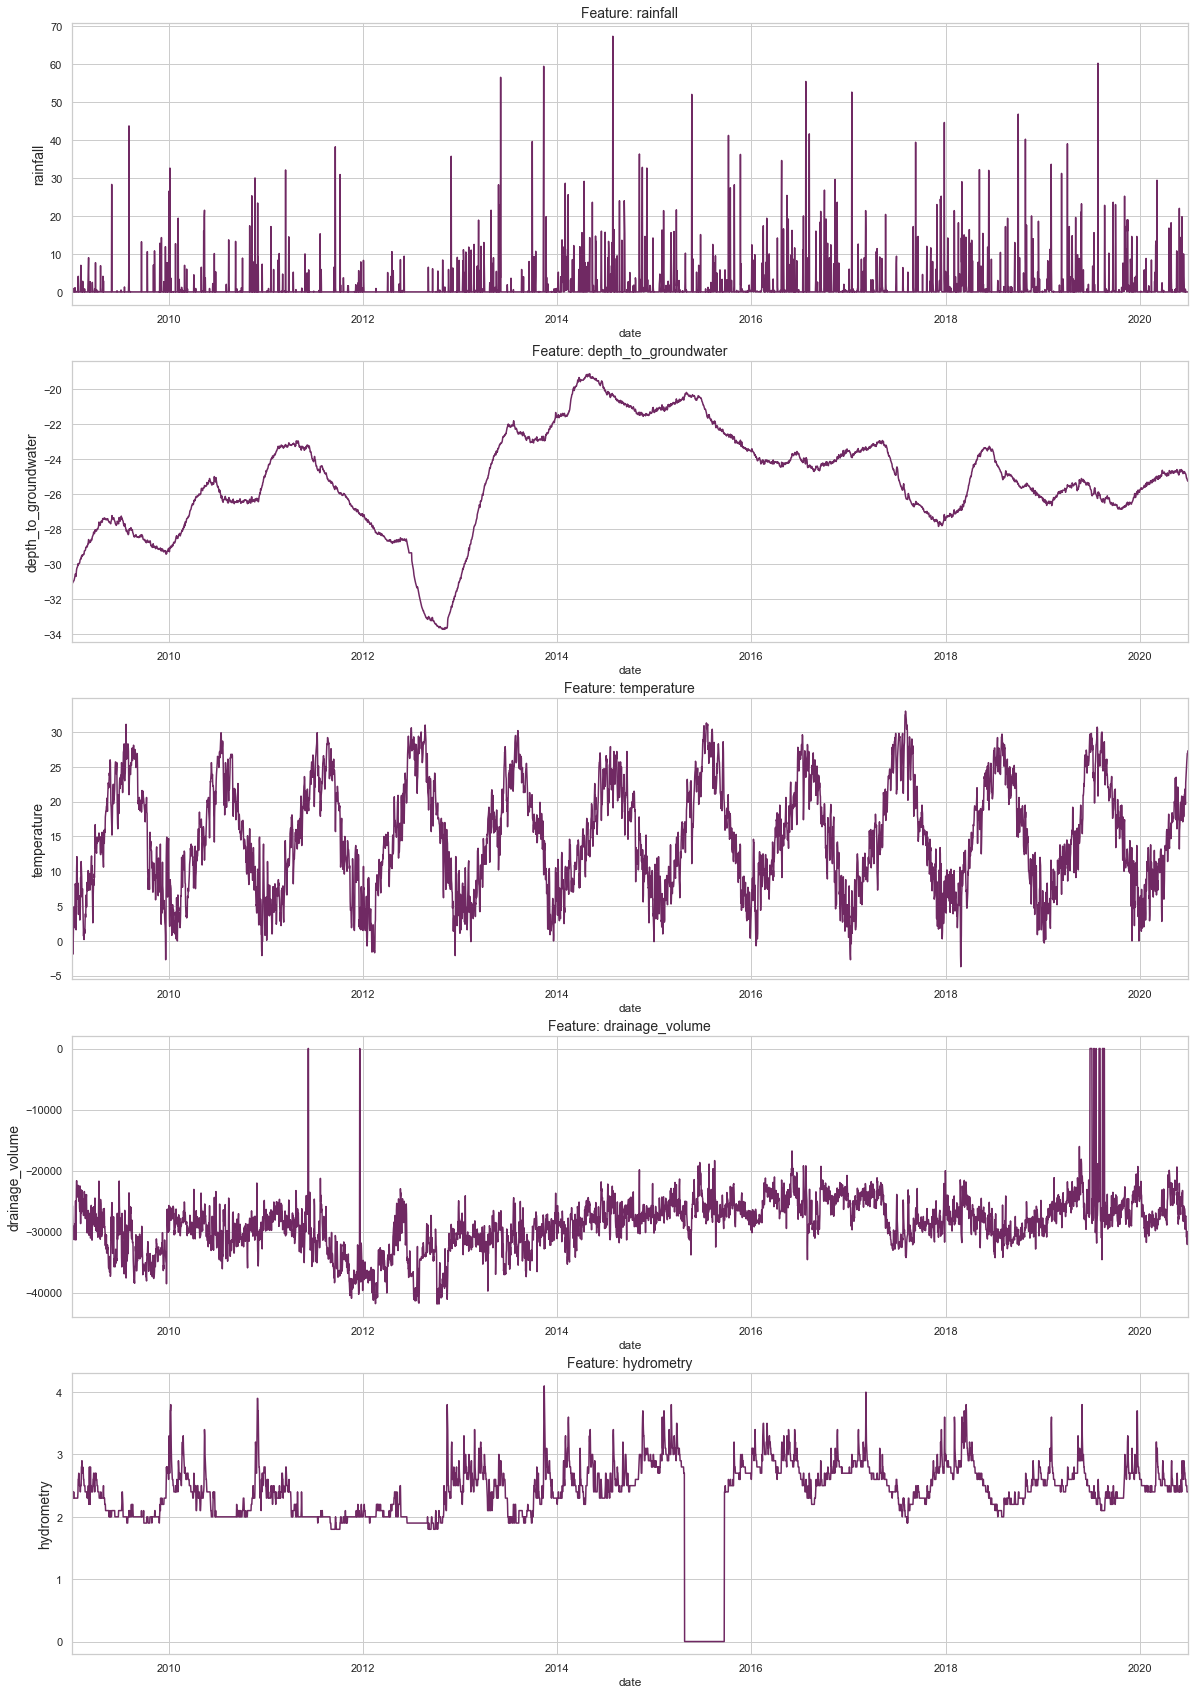

In [13]:
# i will use method ffill to complete the task

f, ax = plt.subplots(nrows=5, ncols=1, figsize=(20,30))

for i, column in enumerate(df.drop('date', axis=1).columns):
    sns.lineplot(x=df['date'], y=df[column].fillna(method='ffill'), ax=ax[i], color='#702963')
    ax[i].set_title('Feature: {}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel=column, fontsize=14)
    ax[i].set_xlim([date(2009,1,1), date(2020,6,30)])
plt.savefig('features_plots.png')

# Data Pre-processing

## **1. Chronological Order and Equidistant Timestamps**

The data should be in chronological order and the timestamps should be equidistant in time series. The chronological order can be achieved by sorting the dataframe by the timestamps. Equidisant timestamps indicates constant time intervals. To check this, the difference between each timestamp can be taken.

In [14]:
df = df.sort_values(by='date')
# check the intervals
df['delta'] = df['date'] - df['date'].shift(1)

df[['date', 'delta']].head()

,date,delta
0,2009-01-01,NaT
1,2009-01-02,1 days
2,2009-01-03,1 days
3,2009-01-04,1 days
4,2009-01-05,1 days


In [15]:
df['delta'].sum()

Timedelta('4198 days 00:00:00')

**Conclusion:** This is already the case in our data: The time interval is one day and the data is already in chronological order. Therefore, we do not have to do this additional data preparation step.

## **2. Missing Values**

In [16]:
df = df.drop('delta', axis=1)

In [17]:
df.isna().sum().to_frame().rename(columns={0:'missing_value'})

,missing_value
date,0
rainfall,0
depth_to_groundwater,27
temperature,0
drainage_volume,1
hydrometry,0


As we can see only two columns `depth_to_groundwater` and `drainage_volume` has missing values.

In next steps I will replace missing value with np.nan and afterwards I will figure out which techniques for missing values apply

**Missing Values: how to handle:**

* Option 1: Fill NaN with Outlier or Zero

>In this specific example filling the missing value with an outlier value such as np.inf or 0 seems to be very naive. However, using values like -999, is sometimes a good idea.

* Option 2: Fill NaN with Mean Value

>Filling NaNs with the mean value is also not sufficient and naive, and doesn't seems to be a good option.

* Option 3: Fill NaN with Last Value with .ffill()

>Filling NaNs with the last value could be bit better.

* Option 4: Fill NaN with Linearly Interpolated Value with .interpolate()

>Filling NaNs with the interpolated values is the best option in this small examlple but it requires knowledge of the neighouring value


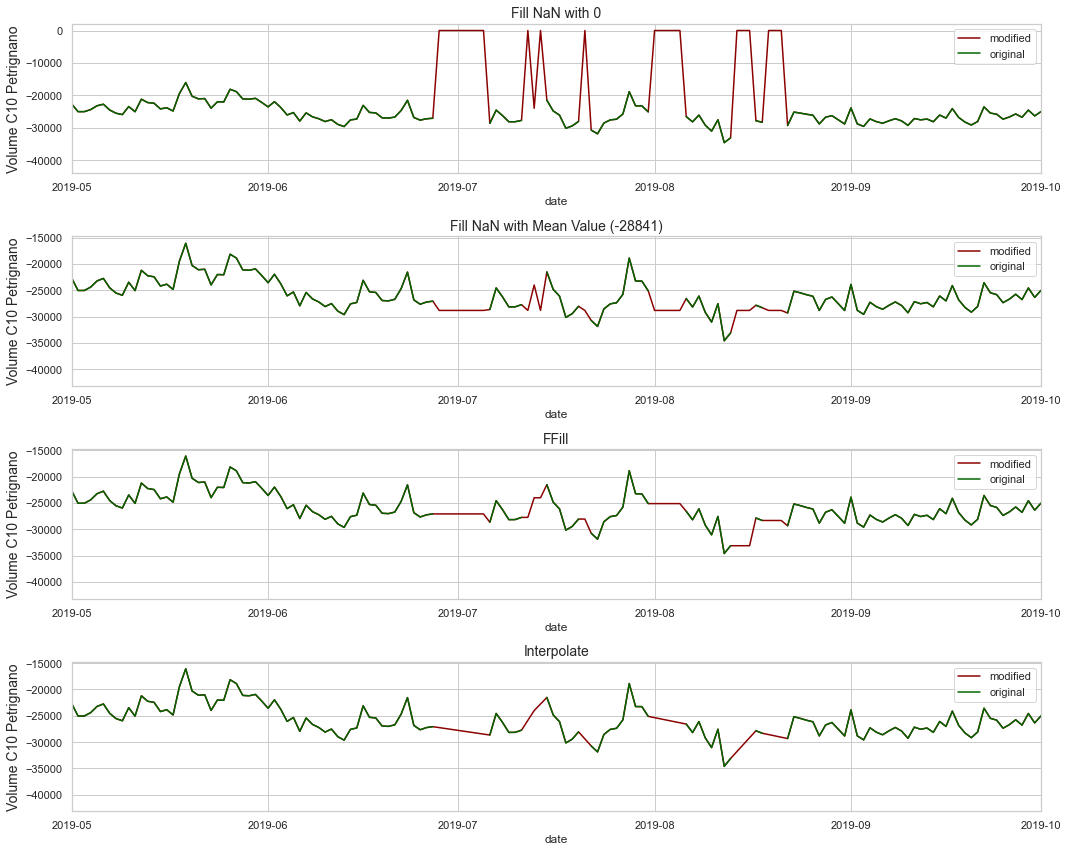

In [20]:
# replacing missing values with np.nan
df['drainage_volume'] = df['drainage_volume'].replace(0, np.nan)
df['depth_to_groundwater'] = df['depth_to_groundwater'].replace(0, np.nan)


f, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 12))

sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(0), ax=ax[0], color='#8b0000', label = 'modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[0], color='#006400', label = 'original')
ax[0].set_title('Fill NaN with 0', fontsize=14)
ax[0].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

mean_depth = df['drainage_volume'].mean()
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(mean_depth), ax=ax[1], color='#8b0000', label = 'modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[1], color='#006400', label = 'original')
ax[1].set_title(f'Fill NaN with Mean Value ({mean_depth:.0f})', fontsize=14)
ax[1].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

sns.lineplot(x=df['date'], y=df['drainage_volume'].ffill(), ax=ax[2], color='#8b0000', label = 'modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[2], color='#006400', label = 'original')
ax[2].set_title(f'FFill', fontsize=14)
ax[2].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

sns.lineplot(x=df['date'], y=df['drainage_volume'].interpolate(), ax=ax[3], color='#8b0000', label = 'modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[3], color='#006400', label = 'original')
ax[3].set_title(f'Interpolate', fontsize=14)
ax[3].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

for i in range(4):
    ax[i].set_xlim([date(2019, 5, 1), date(2019, 10, 1)])
    
plt.tight_layout()
plt.savefig('fill_methods.png')
plt.show()

**Conclusion:** as grapg above shows the best options to deal with missing values in this case is interpolate.

In [21]:
# interpolate missing values
df['drainage_volume'] = df['drainage_volume'].interpolate()
df['depth_to_groundwater'] = df['depth_to_groundwater'].interpolate()

In [22]:
df.isna().sum()

date                    0
rainfall                0
depth_to_groundwater    0
temperature             0
drainage_volume         0
hydrometry              0
dtype: int64

## **3. Smoothing data/Resampling**

Resampling can provide additional information on the data. There are two types of resampling:

* **Upsampling** is when the frequency of samples is increased (e.g. days to hours)
* **Downsampling** is when the frequency of samples is decreased (e.g. days to weeks)


I want to use downsampling and shows orginal `drainage_volume` together with resampling to weekly and monthly data

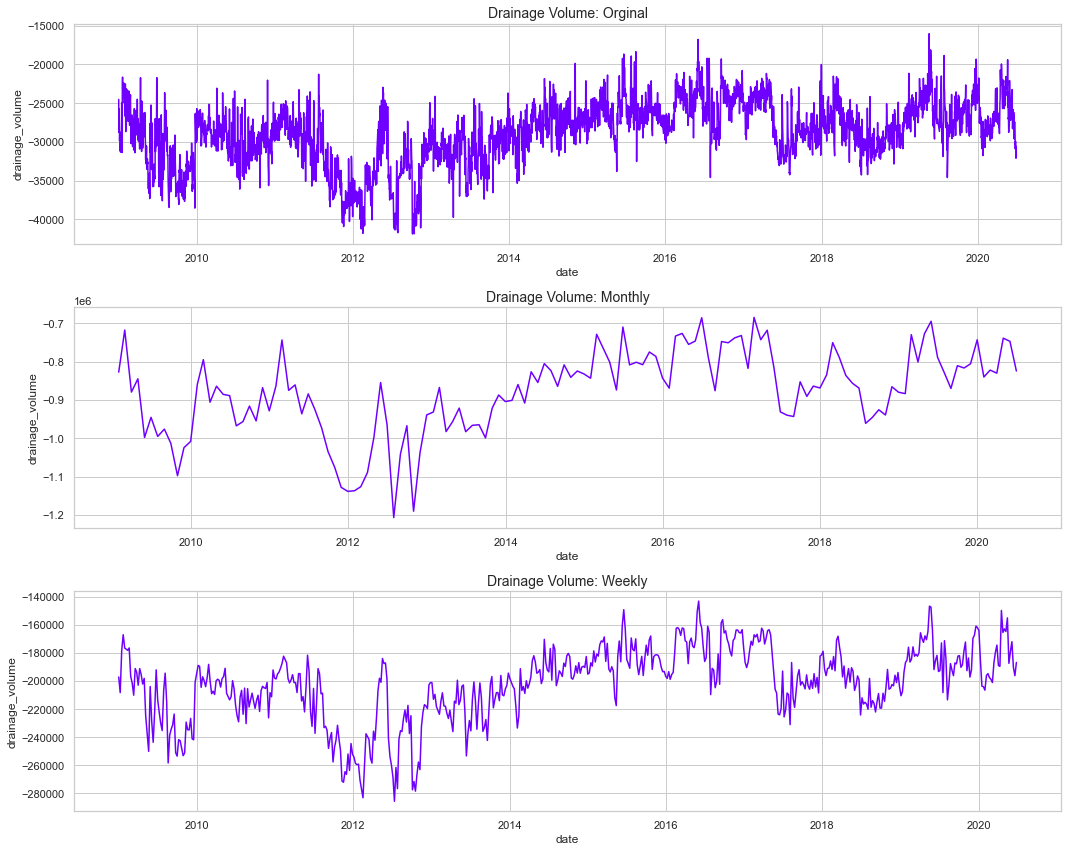

In [23]:
fig, ax = plt.subplots(ncols=1, nrows=3, figsize=(15,12))

sns.lineplot(x=df['date'], y=df['drainage_volume'], ax=ax[0], color='#6f00ff')
ax[0].set_title('Drainage Volume: Orginal', fontsize=14)

resampled_df = df[['date','drainage_volume']].resample('M', on='date').sum().reset_index(drop=False)
sns.lineplot(resampled_df['date'], resampled_df['drainage_volume'], color='#6f00ff', ax=ax[1])
ax[1].set_title('Drainage Volume: Monthly', fontsize=14)

resampled_df = df[['date','drainage_volume']].resample('7D', on='date').sum().reset_index(drop=False)
sns.lineplot(resampled_df['date'], resampled_df['drainage_volume'], color='#6f00ff', ax=ax[2])
ax[2].set_title('Drainage Volume: Weekly', fontsize=14)
    
plt.tight_layout()
plt.savefig('drainage_volume.png')
plt.show()

**Conclusion:** As we can see downsampling to weekly could smooth the data and help with further analysis.

In [24]:
downsample = df[[
    'date', 'rainfall', 'depth_to_groundwater', 'temperature', 'drainage_volume', 'hydrometry'
                ]].resample('7D', on='date').mean().reset_index(drop=False)

df = downsample.copy()

## **4. Stationarity**

To check for stationarity I can use different approaches:

1. Basic statistics 
2. Visually check for trends and seasonality
3. Augmented Dickey-Fuller test

In [25]:
# this functions will help check variance and mean for different columns from our dataframe
#to identyfy if series is stationary or not
def check_chunks(series):
    chunks = np.split(series, indices_or_sections=10)
    print("{} | {:7} | {}".format("Chunk", "Mean", "Variance"))
    print("-" * 26)
    for i, chunk in enumerate(chunks, 1):
        print("{:5} | {:.6} | {:.6}".format(i, np.mean(chunk), np.var(chunk)))

In [26]:
check_chunks(df['depth_to_groundwater'])

Chunk | Mean    | Variance
--------------------------
    1 | -28.5411 | 0.699007
    2 | -25.4695 | 1.63718
    3 | -26.3265 | 3.58245
    4 | -28.6435 | 16.7988
    5 | -21.0593 | 1.65064
    6 | -21.3877 | 0.638419
    7 | -24.0052 | 0.109618
    8 | -25.5095 | 2.90873
    9 | -25.1927 | 0.851852
   10 | -25.6448 | 0.479667


In [27]:
check_chunks(df['temperature'])

Chunk | Mean    | Variance
--------------------------
    1 | 13.4855 | 62.9782
    2 | 13.5919 | 48.33
    3 | 14.9962 | 56.7131
    4 | 16.5012 | 69.8408
    5 | 16.0005 | 44.946
    6 | 15.7357 | 52.6186
    7 | 13.7733 | 54.5865
    8 | 14.6 | 63.0899
    9 | 15.2314 | 52.1986
   10 | 16.4142 | 51.0416


In [28]:
check_chunks(df['rainfall'])

Chunk | Mean    | Variance
--------------------------
    1 | 0.862143 | 2.55088
    2 | 0.895714 | 2.05229
    3 | 0.52 | 1.07104
    4 | 1.0581 | 3.76177
    5 | 2.25429 | 8.83685
    6 | 1.81143 | 5.92673
    7 | 2.40524 | 6.97024
    8 | 1.87286 | 6.43666
    9 | 1.99381 | 5.79725
   10 | 1.88905 | 5.73734


In [29]:
check_chunks(df['drainage_volume'])

Chunk | Mean    | Variance
--------------------------
    1 | -30655.2 | 1.17213e+07
    2 | -29307.5 | 2.40464e+06
    3 | -33187.5 | 1.50471e+07
    4 | -32934.4 | 1.01837e+07
    5 | -28860.2 | 4.62291e+06
    6 | -26304.5 | 2.72211e+06
    7 | -25251.5 | 4.47978e+06
    8 | -27474.4 | 6.69219e+06
    9 | -28193.9 | 5.11633e+06
   10 | -26193.5 | 5.32644e+06


In [30]:
check_chunks(df['hydrometry'])

Chunk | Mean    | Variance
--------------------------
    1 | 2.27476 | 0.0910637
    2 | 2.32548 | 0.0842727
    3 | 2.02048 | 0.00980522
    4 | 2.30452 | 0.133609
    5 | 2.50762 | 0.0861664
    6 | 1.83452 | 1.86766
    7 | 2.78548 | 0.0535135
    8 | 2.6269 | 0.100266
    9 | 2.51143 | 0.0778898
   10 | 2.53413 | 0.055787


Rolling mean and std

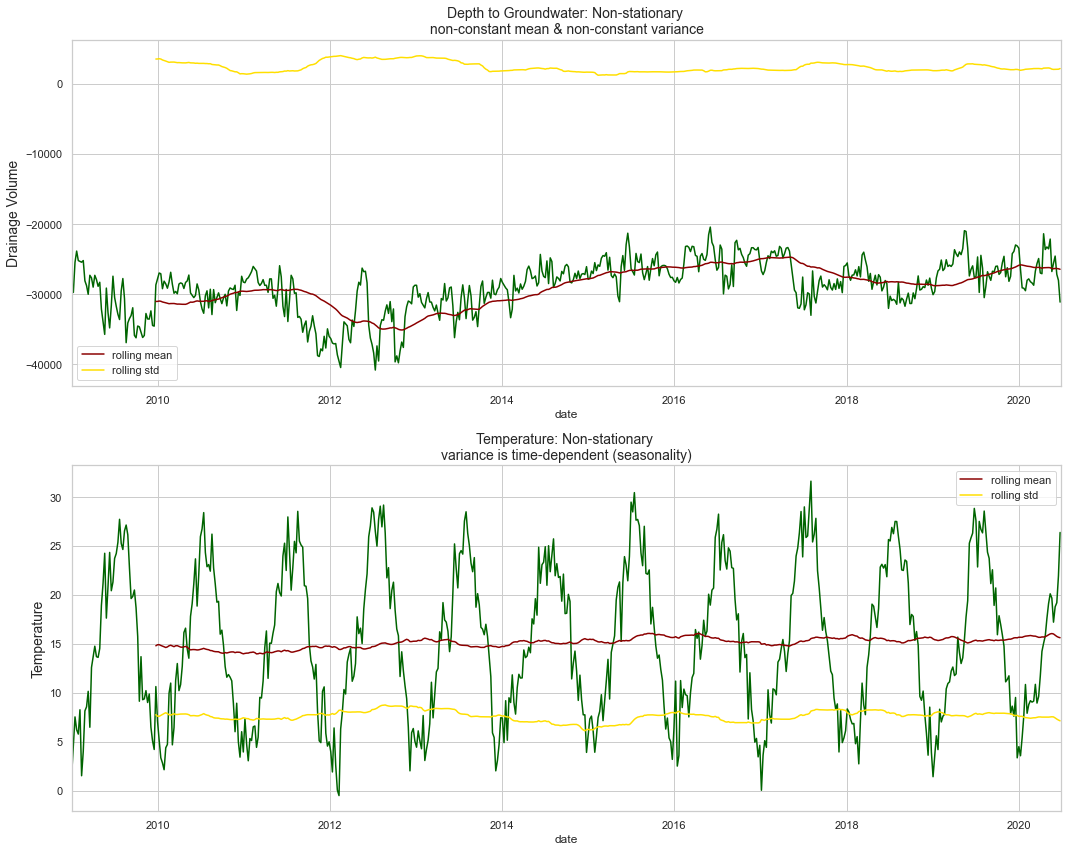

In [31]:
rolling_window = 52
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))

sns.lineplot(x=df['date'], y=df['drainage_volume'], ax=ax[0], color='#006400')
sns.lineplot(x=df['date'], y=df['drainage_volume'].rolling(rolling_window).mean(), ax=ax[0], color='#8b0000', label='rolling mean')
sns.lineplot(x=df['date'], y=df['drainage_volume'].rolling(rolling_window).std(), ax=ax[0], color='#ffdf00', label='rolling std')
ax[0].set_title('Depth to Groundwater: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0].set_ylabel(ylabel='Drainage Volume', fontsize=14)
ax[0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

sns.lineplot(x=df['date'], y=df['temperature'], ax=ax[1], color='#006400')
sns.lineplot(x=df['date'], y=df['temperature'].rolling(rolling_window).mean(), ax=ax[1], color='#8b0000', label='rolling mean')
sns.lineplot(x=df['date'], y=df['temperature'].rolling(rolling_window).std(), ax=ax[1], color='#ffdf00', label='rolling std')
ax[1].set_title('Temperature: Non-stationary \nvariance is time-dependent (seasonality)', fontsize=14)
ax[1].set_ylabel(ylabel='Temperature', fontsize=14)
ax[1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

plt.tight_layout()
plt.savefig('rolling_mean.png')
plt.show()

Let's evaluate the `histograms`. Since we are looking at the mean and variance, we are expecting that the data conforms to a Gaussian distribution (bell shaped distribution) in case of stationarity.

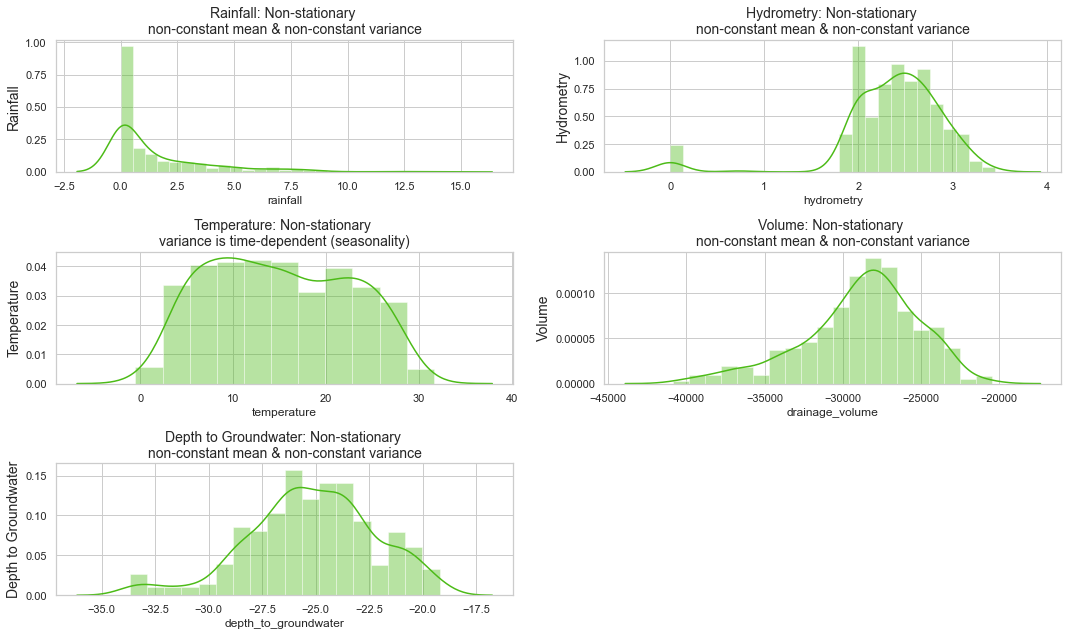

In [32]:
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))

sns.distplot(df.rainfall.fillna(np.inf), ax=ax[0, 0], color='#4cbb17')
ax[0, 0].set_title('Rainfall: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0, 0].set_ylabel(ylabel='Rainfall', fontsize=14)

sns.distplot(df.temperature.fillna(np.inf), ax=ax[1, 0], color='#4cbb17')
ax[1, 0].set_title('Temperature: Non-stationary \nvariance is time-dependent (seasonality)', fontsize=14)
ax[1, 0].set_ylabel(ylabel='Temperature', fontsize=14)

sns.distplot(df.hydrometry.fillna(np.inf), ax=ax[0, 1], color='#4cbb17')
ax[0, 1].set_title('Hydrometry: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0, 1].set_ylabel(ylabel='Hydrometry', fontsize=14)

sns.distplot(df.drainage_volume.fillna(np.inf), ax=ax[1, 1], color='#4cbb17')
ax[1, 1].set_title('Volume: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[1, 1].set_ylabel(ylabel='Volume', fontsize=14)

sns.distplot(df.depth_to_groundwater.fillna(np.inf), ax=ax[2, 0], color='#4cbb17')
ax[2, 0].set_title('Depth to Groundwater: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[2, 0].set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

f.delaxes(ax[2, 1])
plt.tight_layout()
plt.savefig('histograms.png')
plt.show()

**Augmented Dickey-Fuller Test**

This is a statistical procedure to suss out whether a time series is stationary or not. 
1. **Null hypothesis:** the series is nonstationary.
2. **Alternative hypothesis:** the series is stationary.

> The value 0.05 (significance level) is common but depends upons numerous factors.

I'm going to check for each variables adfuller test results and visualize it.

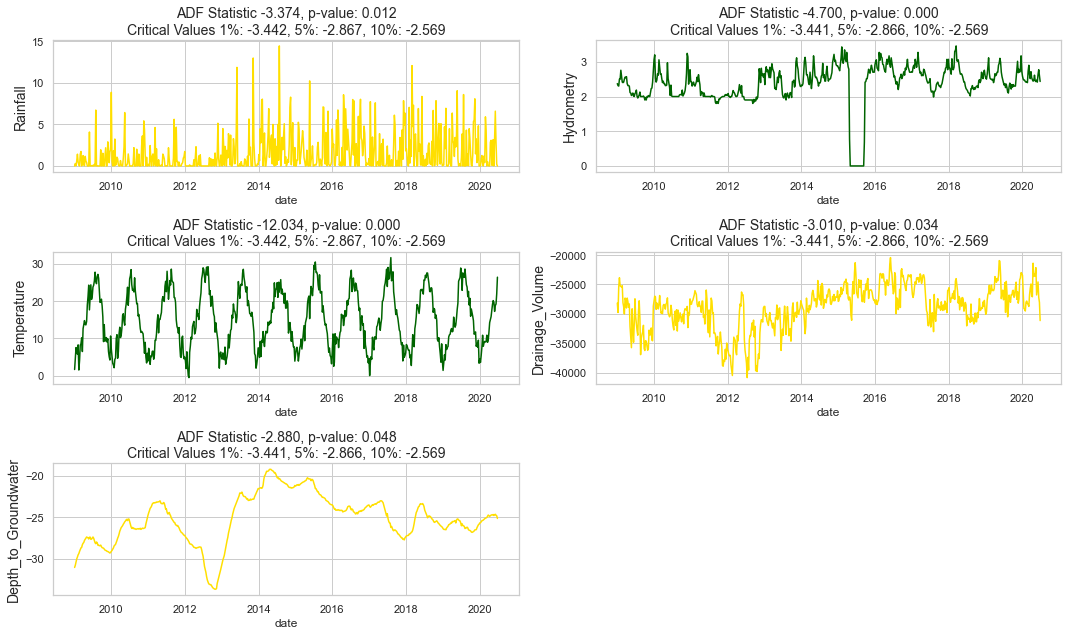

In [35]:
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))

def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = '#006400' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = '#ffdf00'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = '#8b0000'
    else:
        linecolor = '#6f00ff'
        
    sns.lineplot(x=df['date'], y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

visualize_adfuller_results(df['rainfall'].values, 'Rainfall', ax[0, 0])
visualize_adfuller_results(df['temperature'].values, 'Temperature', ax[1, 0])
visualize_adfuller_results(df['hydrometry'].values, 'Hydrometry', ax[0, 1])
visualize_adfuller_results(df['drainage_volume'].values, 'Drainage_Volume', ax[1, 1])
visualize_adfuller_results(df['depth_to_groundwater'].values, 'Depth_to_Groundwater', ax[2, 0])

f.delaxes(ax[2, 1])
plt.tight_layout()
#plt.savefig('afd_test.png')
plt.show()

**Conclusion:** the data is not stationary and further transformation will be needed. 

## **5. Transformation**

The two most common methods to transform series into stationarity ones are:

* **Transformation:** e.g. log or square root to stabilize non-constant variance
* **Differencing:** subtracts the current value from the previous

In [36]:
# log transformation of absolute values
df['depth_to_groundwater_log'] = np.log(abs(df['depth_to_groundwater']))

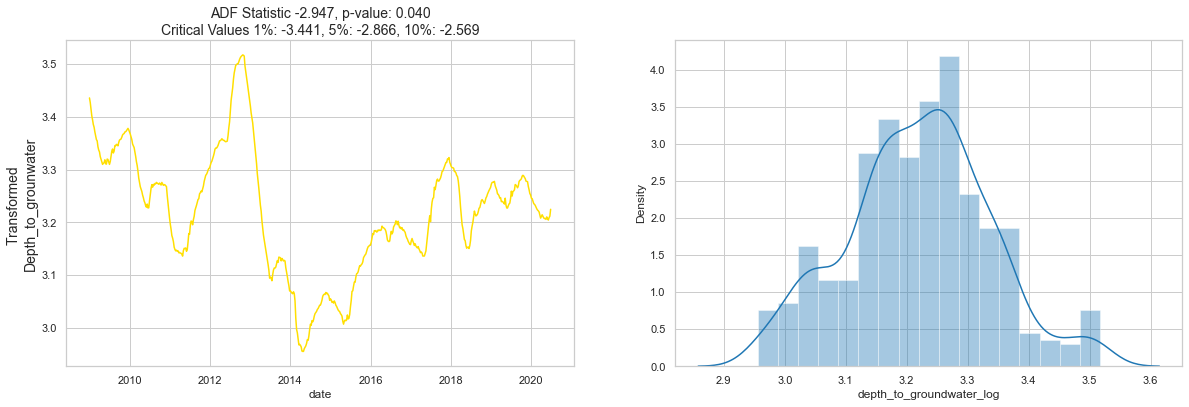

In [37]:
# vizualize the results of log transformations 
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
visualize_adfuller_results(df['depth_to_groundwater_log'], 'Transformed \nDepth_to_grounwater', ax=ax[0])
sns.distplot(df['depth_to_groundwater_log'], ax=ax[1])
plt.savefig('lof_trans.png')

Differencing can be done in different orders:

* First order differencing: linear trends with zi=yi−yi−1
* Second-order differencing: quadratic trends with zi=(yi−yi−1)−(yi−1−yi−2)
* and so on...

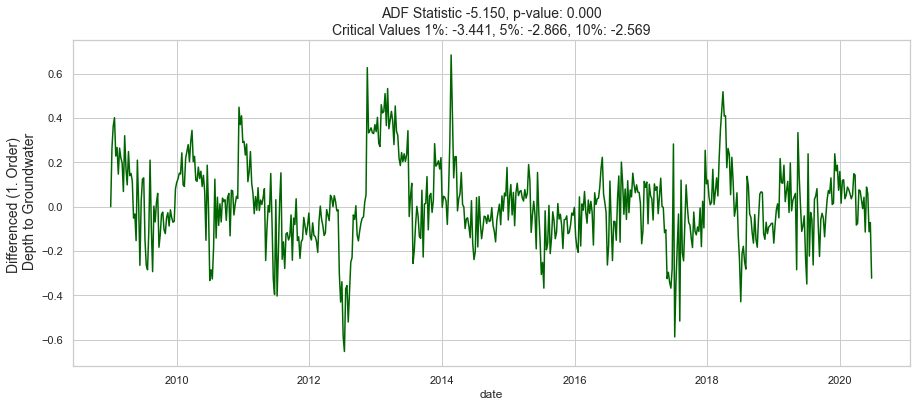

In [38]:
# First Order Differencing
ts_diff = np.diff(df['depth_to_groundwater'])
df['depth_to_groundwater_diff_1'] = np.append([0], ts_diff)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
visualize_adfuller_results(df['depth_to_groundwater_diff_1'], 'Differenced (1. Order) \n Depth to Groundwater', ax)

# Feature engineering

## **1. Cyclical Features**

In [39]:
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month
df['day'] = pd.DatetimeIndex(df['date']).day
df['day_of_year'] = pd.DatetimeIndex(df['date']).dayofyear
df['week_of_year'] = pd.DatetimeIndex(df['date']).weekofyear
df['quarter'] = pd.DatetimeIndex(df['date']).quarter
df['season'] = df['month'] % 12 // 3 + 1

df[['date', 'year', 'month', 'day', 'day_of_year', 'week_of_year', 'quarter', 'season']].head()

,date,year,month,day,day_of_year,week_of_year,quarter,season
0,2009-01-01,2009,1,1,1,1,1,1
1,2009-01-08,2009,1,8,8,2,1,1
2,2009-01-15,2009,1,15,15,3,1,1
3,2009-01-22,2009,1,22,22,4,1,1
4,2009-01-29,2009,1,29,29,5,1,1


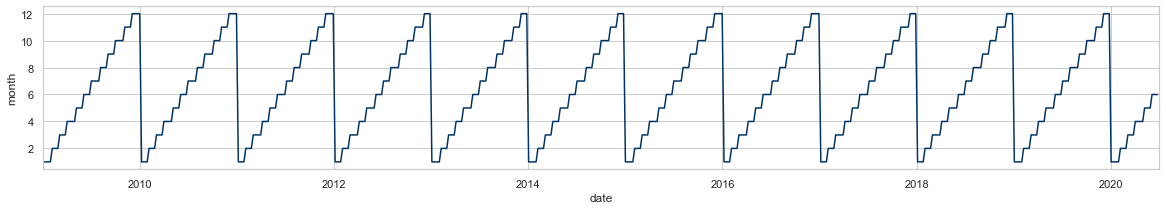

In [40]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 3))

sns.lineplot(x=df['date'], y=df['month'], color='#003366')
ax.set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
plt.savefig('cyclic.png')
plt.show()

The new time features are cyclical. For example,the feature month cycles between 1 and 12 for every year. While the difference between each month increments by 1 during the year, between two years the month feature jumps from 12 (December) to 1 (January).

Let's encode this cyclical feature

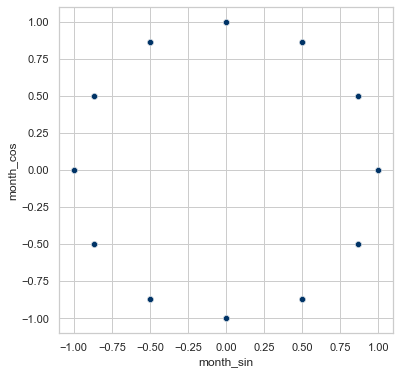

In [41]:
month_in_year = 12
df['month_sin'] = np.sin(2*np.pi*df['month']/month_in_year)
df['month_cos'] = np.cos(2*np.pi*df['month']/month_in_year)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.scatterplot(x=df.month_sin, y=df.month_cos, color='#003366')
plt.show()

## **2. Time Series Decomposition**

Time series decomposition involves thinking of a series as a combination of level, trend, seasonality, and noise components.

These components are defined as follows:

* Level: The average value in the series.
* Trend: The increasing or decreasing value in the series.
* Seasonality: The repeating short-term cycle in the series.
* Noise: The random variation in the series.

In [42]:
core_columns =  [
    'rainfall', 'temperature', 'drainage_volume', 
    'hydrometry', 'depth_to_groundwater'
]

for column in core_columns:
    decomp = seasonal_decompose(df[column], period=52, model='additive', extrapolate_trend='freq')
    df[f"{column}_trend"] = decomp.trend
    df[f"{column}_seasonal"] = decomp.seasonal
    df[f"{column}_residual"] = decomp.resid

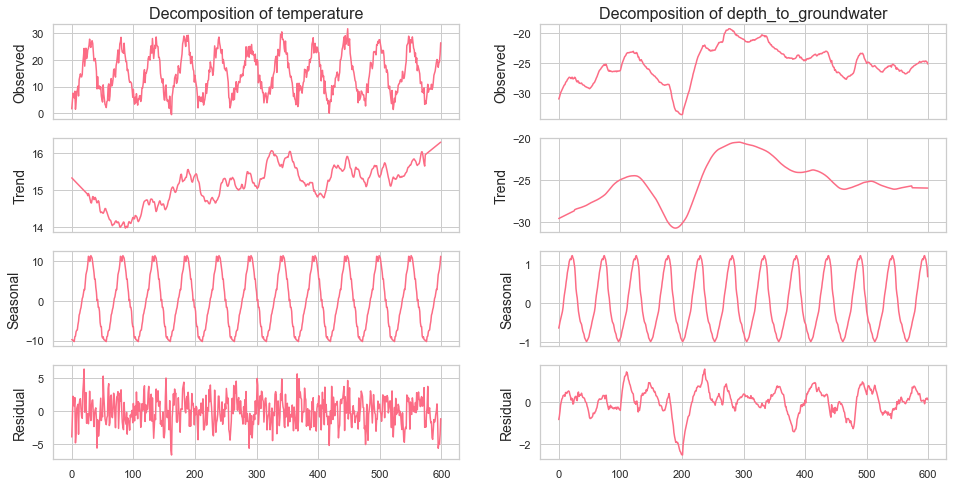

In [43]:
fig, ax = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(16,8))

for i, column in enumerate(['temperature', 'depth_to_groundwater']):
    
    res = seasonal_decompose(df[column], freq=52, model='additive', extrapolate_trend='freq')

    ax[0,i].set_title('Decomposition of {}'.format(column), fontsize=16)
    res.observed.plot(ax=ax[0,i], legend=False, color='#fc6c85')
    ax[0,i].set_ylabel('Observed', fontsize=14)

    res.trend.plot(ax=ax[1,i], legend=False, color='#fc6c85')
    ax[1,i].set_ylabel('Trend', fontsize=14)

    res.seasonal.plot(ax=ax[2,i], legend=False, color='#fc6c85')
    ax[2,i].set_ylabel('Seasonal', fontsize=14)
    
    res.resid.plot(ax=ax[3,i], legend=False, color='#fc6c85')
    ax[3,i].set_ylabel('Residual', fontsize=14)

plt.savefig('decomposition.png')
plt.show()

## **3. Lag**

I want to calculate each variable with a shift() (lag) to compare the correlationwith the other variables

In [44]:
weeks_in_month = 4

for column in core_columns:
    df[f'{column}_seasonal_shift_b_2m'] = df[f'{column}_seasonal'].shift(-2 * weeks_in_month)
    df[f'{column}_seasonal_shift_b_1m'] = df[f'{column}_seasonal'].shift(-1 * weeks_in_month)
    df[f'{column}_seasonal_shift_1m'] = df[f'{column}_seasonal'].shift(1 * weeks_in_month)
    df[f'{column}_seasonal_shift_2m'] = df[f'{column}_seasonal'].shift(2 * weeks_in_month)
    df[f'{column}_seasonal_shift_3m'] = df[f'{column}_seasonal'].shift(3 * weeks_in_month)

# Exploratory Data Analysis

## **1. Seasonal Components of Features**

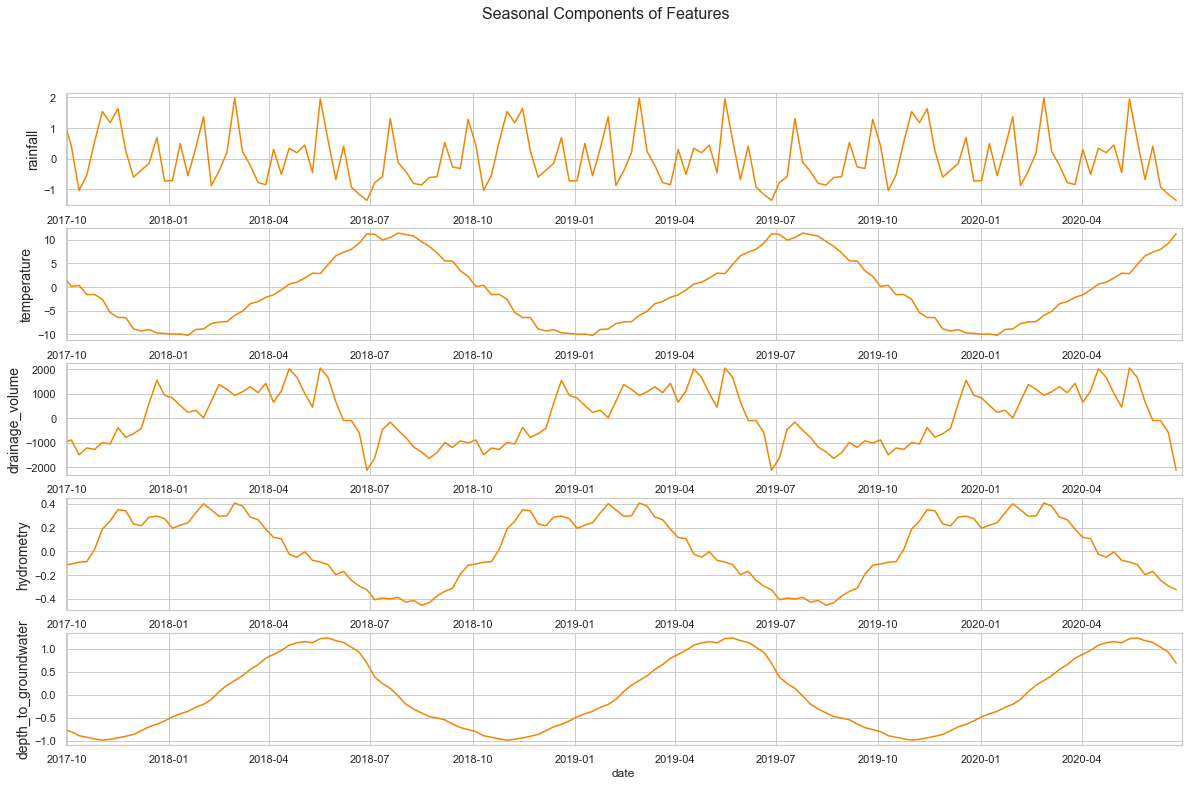

In [45]:
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(20, 12))

for i, column in enumerate(core_columns):
    sns.lineplot(x=df['date'], y=df[column + '_seasonal'], ax=ax[i], color='#f28500')
    ax[i].set_ylabel(ylabel=column, fontsize=14)
    ax[i].set_xlim([date(2017, 9, 30), date(2020, 6, 30)])
    
f.suptitle('Seasonal Components of Features', fontsize=16)
plt.savefig('sesonal_features.png')

**Conclusion:**

* **depth_to_groundwater:** reaches its maximum around May/June and its minimum around November
* **temperature:** reaches its maxmium around August and its minimum around January
* **drainage_volume:** reaches its minimum around June and rapidly decrease in July
* **hydrometry:** reaches its maximum around February/March and its minimum around September

## **2. Correlations and Heatmap**

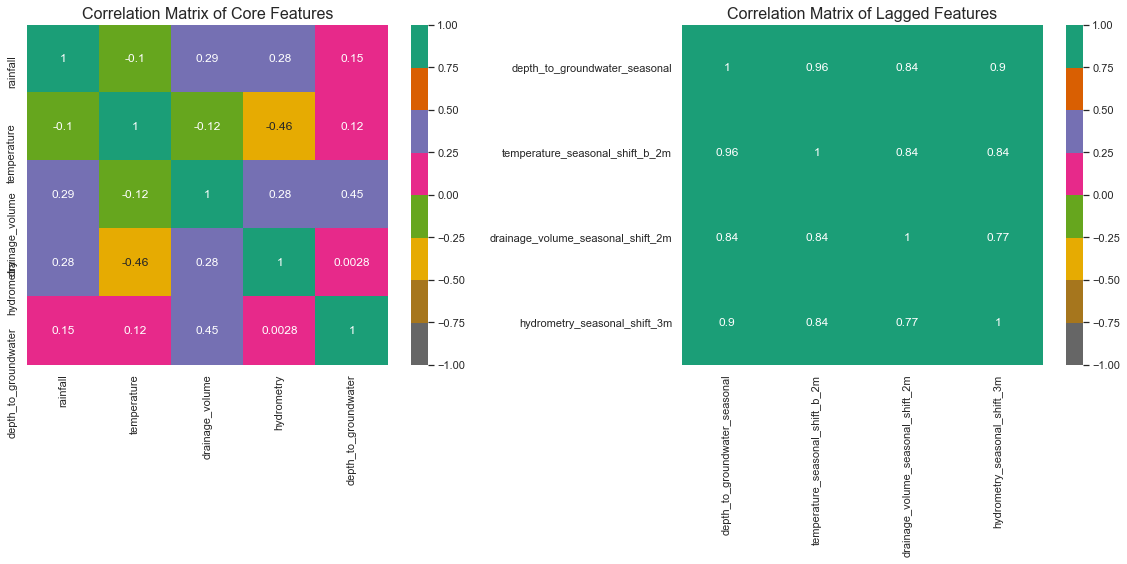

In [46]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

corrmat = df[core_columns].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='Dark2_r', ax=ax[0])
ax[0].set_title('Correlation Matrix of Core Features', fontsize=16)

shifted_cols = [
    'depth_to_groundwater_seasonal',         
    'temperature_seasonal_shift_b_2m',
    'drainage_volume_seasonal_shift_2m', 
    'hydrometry_seasonal_shift_3m'
]
corrmat = df[shifted_cols].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='Dark2_r', ax=ax[1])
ax[1].set_title('Correlation Matrix of Lagged Features', fontsize=16)

plt.tight_layout()
plt.savefig('heatmap.png')
plt.show()

**Conclusion:** shifted features are highly correlated than original one.

## **3. Autocorrelations Analysis**

By looking at the autocorrelation function (ACF) and partial autocorrelation (PACF) plots of the differenced series, you can tentatively identify the numbers of AR and/or MA terms that are needed.

* **Autocorrelation Function (ACF):** P = Periods to lag for eg: (if P= 3 then we will use the three previous periods of our time series in the autoregressive portion of the calculation) P helps adjust the line that is being fitted to forecast the series. P corresponds with MA parameter
* **Partial Autocorrelation Function (PACF):** D = In an ARIMA model we transform a time series into stationary one(series without trend or seasonality) using differencing. D refers to the number of differencing transformations required by the time series to get stationary. D corresponds with AR parameter.

Autocorrelation plots help in detecting seasonality

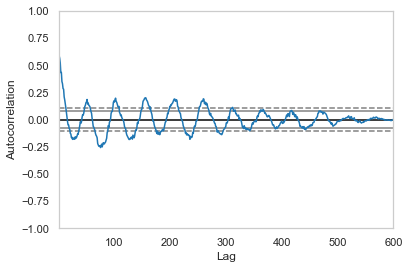

In [47]:
autocorrelation_plot(df['depth_to_groundwater_diff_1'])

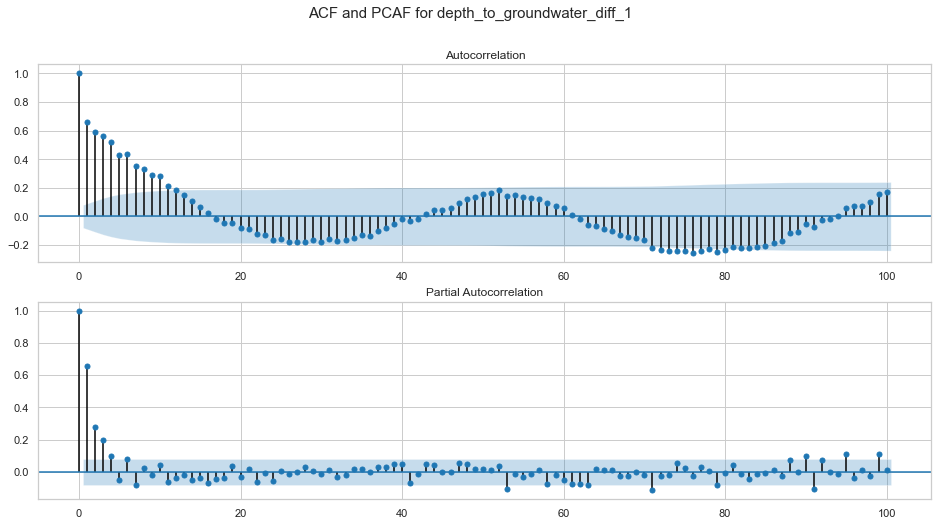

In [49]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16,8))
plot_acf(df['depth_to_groundwater_diff_1'], lags=100, ax=ax[0])
plot_pacf(df['depth_to_groundwater_diff_1'], lags=100, ax=ax[1])
f.suptitle('ACF and PCAF for depth_to_groundwater_diff_1', fontsize=15)
plt.savefig('acf_pacf.png')
plt.show()

# Modeling

Time series can be either univariate or multivariate:

* **Univariate** time series only has a single time-dependent variable
* **Multivariate** time series have a multiple time-dependent variable

In this notebook I will focus on univariate time series analysis.
> Only one variable is varying over time. For example, data collected from a sensor measuring the temperature of a room every second. Therefore, each second, you will only have a one-dimensional value, which is the temperature.

I will try to predict `depth_to_groundwater` 

In [50]:
train_size = int(0.85 * len(df))
test_size = len(df) - train_size

univariate_df = df[['date', 'depth_to_groundwater']].copy()
univariate_df.columns = ['ds', 'y']

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(len(train), len(x_valid))

510 90


In [51]:
train

,ds,y
0,2009-01-01,-31.048571
1,2009-01-08,-30.784286
2,2009-01-15,-30.420000
3,2009-01-22,-30.018571
4,2009-01-29,-29.790000
...,...,...
505,2018-09-06,-25.030000
506,2018-09-13,-25.194286
507,2018-09-20,-25.230000
508,2018-09-27,-25.378571


In [52]:
univariate_df

,ds,y
0,2009-01-01,-31.048571
1,2009-01-08,-30.784286
2,2009-01-15,-30.420000
3,2009-01-22,-30.018571
4,2009-01-29,-29.790000
...,...,...
595,2020-05-28,-24.697143
596,2020-06-04,-24.638571
597,2020-06-11,-24.751429
598,2020-06-18,-24.822857


## **1. Prophet**

In [53]:
# Train the model
model = Prophet(weekly_seasonality=True, daily_seasonality=False)
model.fit(train)

# x_valid = model.make_future_dataframe(periods=test_size, freq='w')

# Predict on valid set
y_pred = model.predict(x_valid)

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred.tail(test_size)['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred.tail(test_size)['yhat']))

print('RMSE: {}'.format(score_rmse))
print('MAE: {}'.format(score_mae))

RMSE: 1.2011168393294425
MAE: 0.9846236332120482


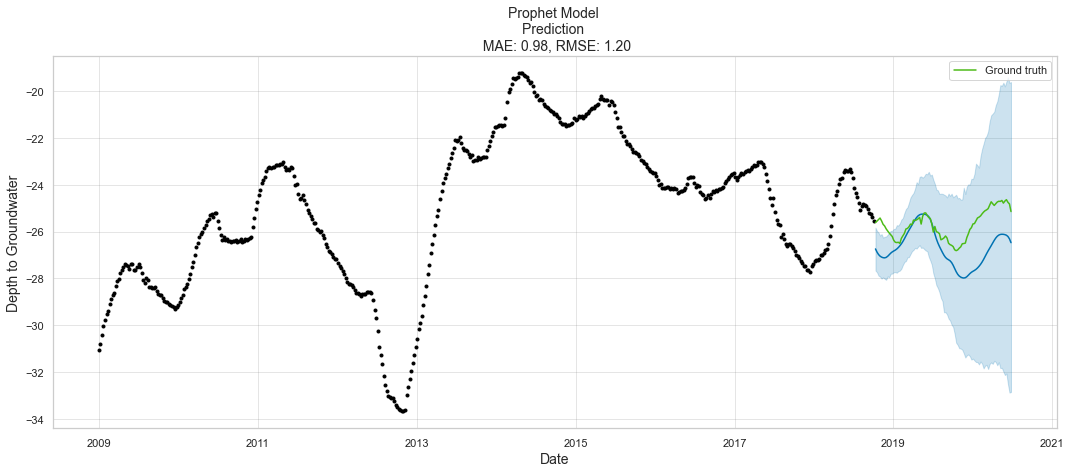

In [54]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

model.plot(y_pred, ax=ax)
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='#4cbb17', label='Ground truth') 

ax.set_title(f'Prophet Model \nPrediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.savefig('prophet.png')
plt.show()

## **2. ARIMA**

Steps to analyze ARIMA

* **Step 1** — Check stationarity: If a time series has a trend or seasonality component, it must be made stationary before we can use ARIMA to forecast. .
* **Step 2** — Difference: If the time series is not stationary, it needs to be stationarized through differencing. Take the first difference, then check for stationarity. Take as many differences as it takes. Make sure you check seasonal differencing as well.
* **Step 3** — Filter out a validation sample: This will be used to validate how accurate our model is. Use train test validation split to achieve this
* **Step 4** — Select AR and MA terms: Use the ACF and PACF to decide whether to include an AR term(s), MA term(s), or both.
* **Step 5** — Build the model: Build the model and set the number of periods to forecast to N (depends on your needs).
* **Step 6** — Validate model: Compare the predicted values to the actuals in the validation sample.

In [55]:
# Fit model
model = ARIMA(y_train, order=(1,1,1))
model_fit = model.fit()

# Prediction with ARIMA
y_pred, se, conf = model_fit.forecast(90)

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred)
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred))

print('RMSE: {}'.format(score_rmse))
print('MAE: {}'.format(score_mae))

RMSE: 0.8858307128891101
MAE: 0.7410049668929177


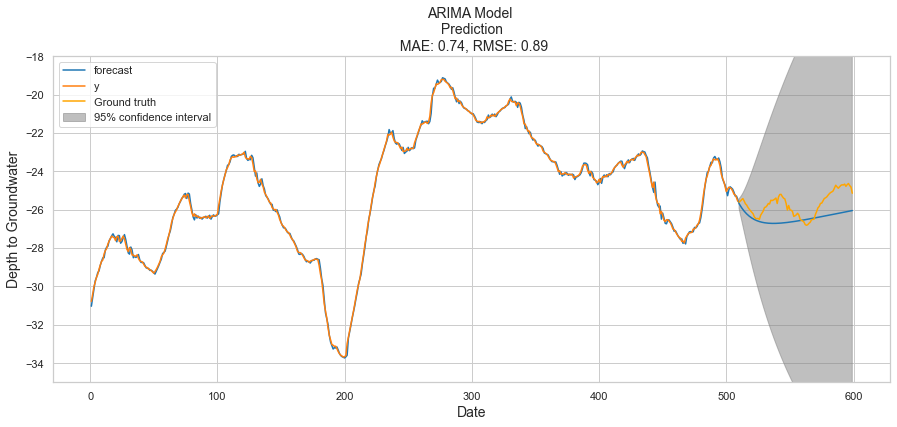

In [56]:
# plot forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

model_fit.plot_predict(1, 599, ax=ax)
sns.lineplot(x=x_valid.index, y=y_valid['y'], ax=ax, color='orange', label='Ground truth')

ax.set_title(f'ARIMA Model \n Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)
ax.set_ylim(-35, -18)
ax.legend(loc='upper left')
plt.savefig('arima.png')
plt.show()

## **3. Auto-ARIMA**

In [57]:
model = pm.auto_arima(y_train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-631.136, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-242.692, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-574.047, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-427.347, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-243.054, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-629.209, Time=1.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-629.237, Time=0.82 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-492.779, Time=0.24 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-611.065, Time=0.23 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-628.351, Time=1.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-632.995, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-428.258, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-575.735, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-631.069, Time=0.30 sec
 ARIMA(1,1,2)(0,0,0)[0]          

As we saw in the previous Steps, AutoARIMA (auto_arima) validates that (1,1,1) is the best configuration for (p,d,q).

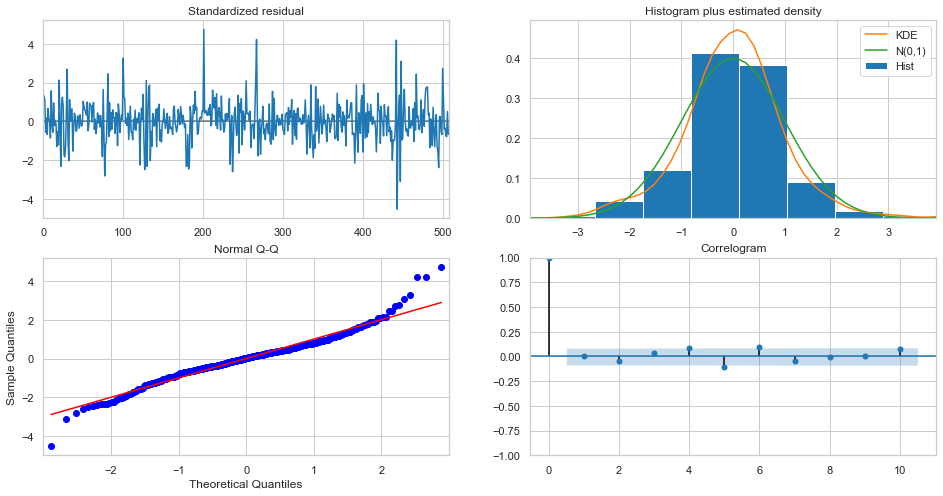

In [58]:
model.plot_diagnostics(figsize=(16,8))
plt.savefig('auto_arima.png')
plt.show()

**How to interpret the plot diagnostics?**

>Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance between (-4, 4).

>Top Right: The density plot suggest normal distribution with mean zero.

>Bottom left: The most part of the blue dots are over the red line, so it seems that the distribution in very low skewed (not skewed for me).

>Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated.

## **4. LSTM**

I am going to use a multi-layered LSTM recurrent neural network to predict the last value of a sequence of values.

The following data pre-processing and feature engineering need to be done before construct the LSTM model.

* Create the dataset, ensure all data is float
* Normalize the features
* Split into training and test sets
* Convert an array of values into a dataset matrix
* Reshape into X=t and Y=t+1
* Reshape input to be 3D (num_samples, num_timesteps, num_features)

In [59]:
data = univariate_df.filter(['y'])

#Convert the dataframe to a numpy array
dataset = data.values

scaler = MinMaxScaler(feature_range=(-1, 0))
scaled_data = scaler.fit_transform(dataset)

scaled_data[:10]

array([[-0.81796644],
       [-0.79970385],
       [-0.7745311 ],
       [-0.74679171],
       [-0.73099704],
       [-0.71253702],
       [-0.7023692 ],
       [-0.68410661],
       [-0.66890424],
       [-0.65528134]])

In [60]:
# Defines the rolling window
look_back = 52
# Split into train and test sets
train, test = scaled_data[:train_size-look_back,:], scaled_data[train_size-look_back:,:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        a = dataset[i-look_back:i, 0]
        X.append(a)
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

x_train, y_train = create_dataset(train, look_back)
x_test, y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

print(len(x_train), len(x_test))

406 90


In [61]:
#Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=5, validation_data=(x_test, y_test))

model.summary()

Epoch 1/5
406/406 [==============================] - 8s 9ms/step - loss: 0.0158 - val_loss: 0.0045
Epoch 2/5
406/406 [==============================] - 2s 6ms/step - loss: 0.0025 - val_loss: 7.3857e-04
Epoch 3/5
406/406 [==============================] - 2s 6ms/step - loss: 0.0019 - val_loss: 4.5496e-04
Epoch 4/5
406/406 [==============================] - 2s 6ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 5/5
406/406 [==============================] - 2s 6ms/step - loss: 0.0015 - val_loss: 0.0013
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 128)            92672     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 25)                1625      
_______________

In [62]:
# Lets predict with the model
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])

test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Get the root mean squared error (RMSE) and MAE
score_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
score_mae = mean_absolute_error(y_test[0], test_predict[:,0])

print('RMSE: {}'.format(score_rmse))
print('MAE: {}'.format(score_mae))

RMSE: 0.5175639945969681
MAE: 0.4586139892093717


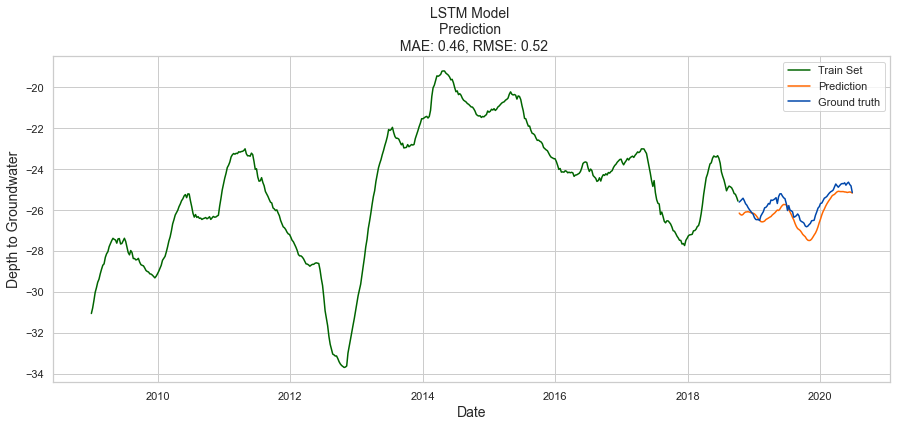

In [63]:
# visualize results
x_train_ticks = univariate_df.head(train_size)['ds']
y_train = univariate_df.head(train_size)['y']
x_test_ticks = univariate_df.tail(test_size)['ds']

# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

sns.lineplot(x=x_train_ticks, y=y_train, ax=ax, label='Train Set', color='#006400') 
sns.lineplot(x=x_test_ticks, y=test_predict[:,0], ax=ax, color='#ff6700', label='Prediction')
sns.lineplot(x=x_test_ticks, y=y_test[0], ax=ax, color='#0047ab', label='Ground truth')

ax.set_title(f'LSTM Model \nPrediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.savefig('lstm.png')
plt.show()

# Conclusions

The best model in this analysis was LSTM. 